In [1]:
import matplotlib.pylab as plt
import numpy as np
import zlib
import glob
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from generator_class import DataGenerator
from tensorflow.keras.optimizers import SGD
import json
import argparse
import pandas as pd
#GPU/CPU Selection
gpu_setting = 'y'

from eval_utils import *

2024-01-25 20:48:40.147730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
from scipy.stats import beta
from sklearn.metrics import confusion_matrix

In [2]:
plt.style.use('/home/sophiaf/mystyle.mplstyle')

In [3]:
history_file = 'CNN/ResNet_20240119_3output_training_history_first16.json' # 'ResNet_v2_128training_history.json'
# history_file = 'CNN/ResNet_v2_20240104_urllist0training_history.json' # 'ResNet_v2_128training_history.json'
# Opening JSON file
f = open(history_file)
# returns JSON object as 
# a dictionary
hst = json.load(f)
f.close()

In [4]:
history_file = 'CNN/ResNet_20240119_3output_training_history_first16.json' # 'ResNet_v2_128training_history.json'
history_2_file = 'CNN/ResNet_20240119_3output_training_history.json'
model = 'ResNet_20240119_3output'
# history_file = 'CNN/ResNet_v2_20240104_urllist0training_history.json' # 'ResNet_v2_128training_history.json'
# Opening JSON file
f = open(history_file)
# returns JSON object as 
# a dictionary
hst = json.load(f)
f.close()

f = open(history_2_file)
# returns JSON object as 
# a dictionary
hst2 = json.load(f)
f.close()

for key in hst.keys():
    hst[key].extend(hst2[key])

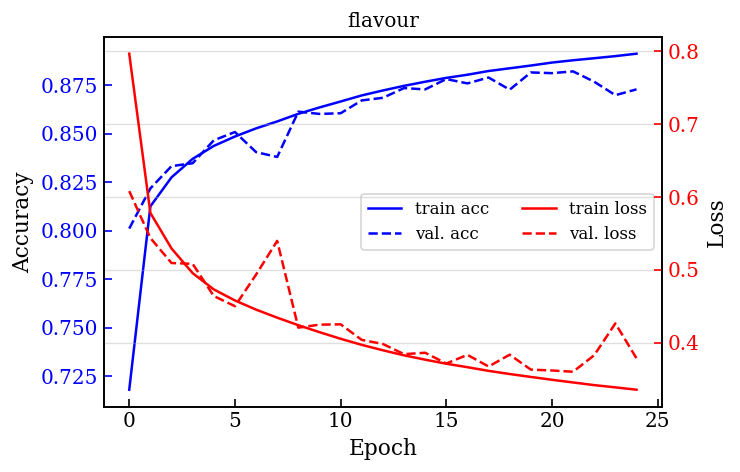

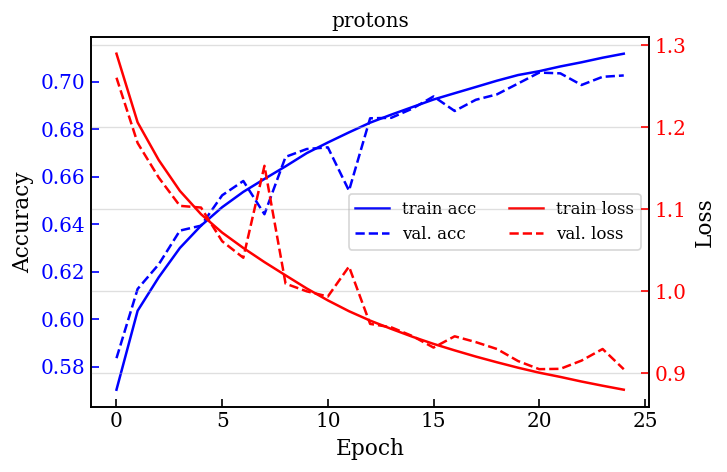

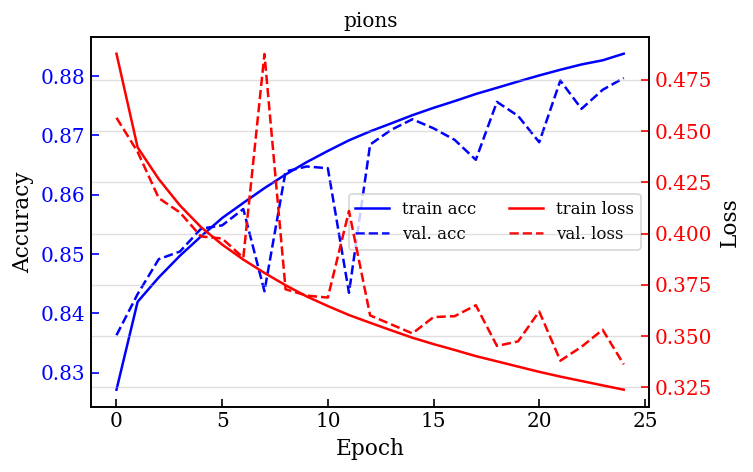

In [123]:
things_to_plot = ['flavour', 'protons', 'pions', 'pizeros', 'neutrons', 'is_antineutrino']
things_to_plot = ['flavour', 'protons', 'pions']
for thing_to_plot in things_to_plot:
    fig, ax = plt.subplots()
    ax.tick_params('y', colors='b')
    ax.set(ylabel='Accuracy', xlabel='Epoch')
    acc = plt.plot(hst['%s_accuracy'%(thing_to_plot)], c='b', ls='-', label='train acc')
    valacc = plt.plot(hst['val_%s_accuracy'%(thing_to_plot)], c='b', ls='--', label='val. acc')
    
# Get second axis
    ax2 = ax.twinx()
    ax2.tick_params('y', colors='r')
    ax2.set(ylabel='Loss')
    loss = plt.plot(hst['%s_loss'%(thing_to_plot)], c='r', ls='-', label='train loss')
    valloss = plt.plot(hst['val_%s_loss'%(thing_to_plot)], c='r', ls='--', label='val. loss')
    # plt.ylim(0.25,.9)

    lns = acc+valacc+loss+valloss
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='center right', ncol=2)
    # plt.legend(loc='center right', ncol=2)
    plt.xlabel('epoch')
    plt.grid()
    plt.title(thing_to_plot)
    plt.savefig('model_eval_plots/history_%s_%s.pdf'%(thing_to_plot, model))
    plt.show()

## Evaluating test sample

In [5]:
model_name = 'ResNet_20240119_3output' # 'ResNet_v2_20240115_6layers_test'
os.makedirs('model_eval_plots/%s'%(model_name), exist_ok=True)
tests = pd.read_pickle('CNN/%s_test_predictions.pkl'%(model_name))

In [6]:
test_data_w_angle = pd.read_pickle('/home/sophiaf/pixel_maps_val/preprocessed_filelists/urllist_0_1_2_10_11_12_b_df_testset.pkl')
test_data = pd.read_pickle('/home/sophiaf/pixel_maps_val/preprocessed_filelists/scratch_urllist_0_1_2_10_11_12_df_testset.pkl')
test_data['LepAngle'] = test_data_w_angle['LepAngle']

In [7]:
test_data.shape

(142324, 16)

In [8]:
# full outputs 
cls_tasks = ['flavour', 'protons', 'pions', 'pizeros', 'neutrons', 'is_antineutrino']
output_options = [3,4,4,4,4,2]
colors = [ 'green','crimson', 'navy', 'mediumorchid',]
pred = tests['pred']
true = tests['true'].iloc[:len(pred[0])] # batches cut off preds 
true_meta = test_data.iloc[:len(pred[0])]

In [9]:
labels_flavour = ['NC', '$\\nu_e$ CC', '$\\nu_{\\mu}$ CC']
labels_n_particles = ['N=0', 'N=1', 'N=2', 'N=3+']
labels_is_anti = ['$\\nu$', '$\\bar{\\nu}$']

key_labels = {'flavour': labels_flavour, 'protons': labels_n_particles, 
                 'pions': labels_n_particles,
                 'pizeros': labels_n_particles,
                 'neutrons': labels_n_particles,
                 'is_antineutrino': labels_is_anti}

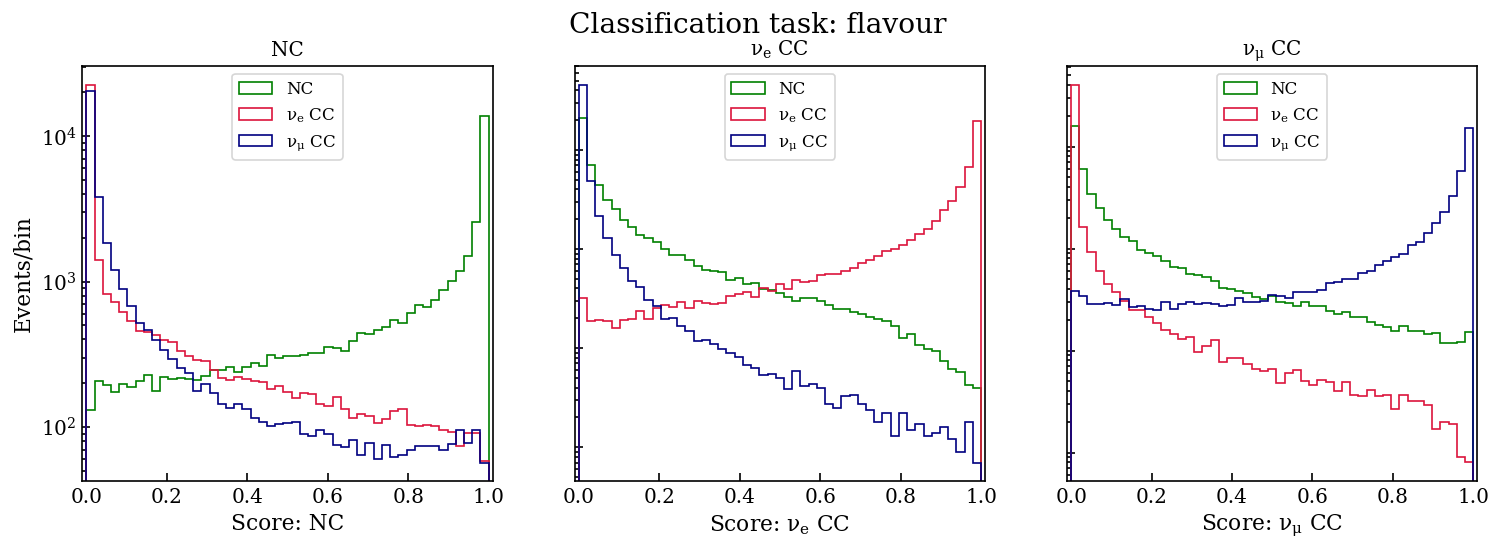

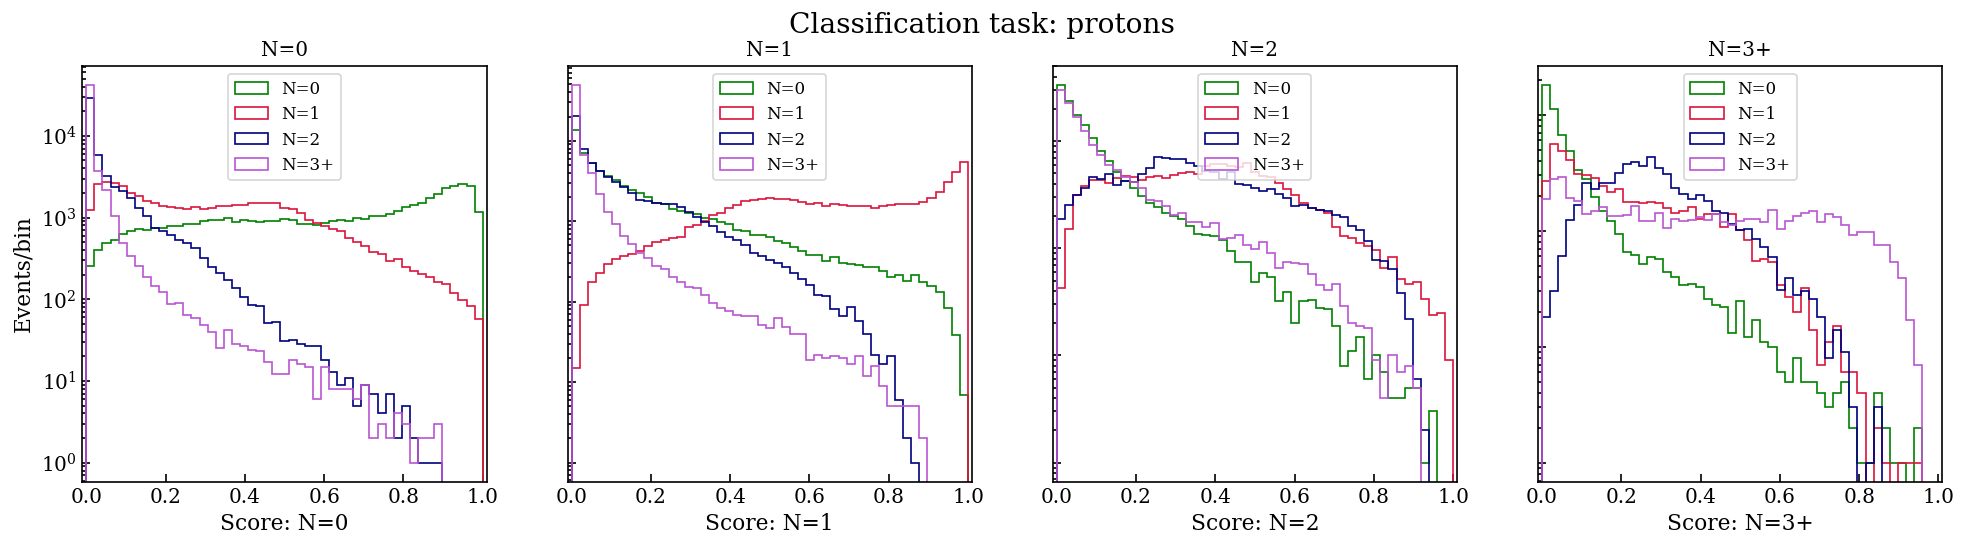

ValueError: The 'color' keyword argument must have one color per dataset, but 2 datasets and 1 colors were provided

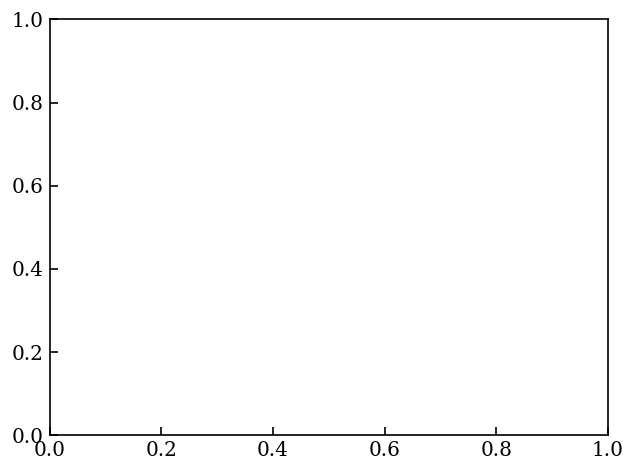

In [20]:
for cls_task in cls_tasks:
# cls_task = 'is_antineutrino' 
    num_in_pred = output_options[cls_tasks.index(cls_task)]
    class_options = np.arange(0, num_in_pred)
    cls_labels = key_labels[cls_task]
    
    if num_in_pred >2: 
        fig, axs = plt.subplots(1, len(class_options), figsize=(5*len(class_options),4.5))
        for cls, ax in zip(class_options, axs.flat):
            these_preds = pred[cls_tasks.index(cls_task)]
            for i in class_options:
                ax.hist(these_preds[true[cls_task]==cls][:,i], bins=np.linspace(0,1,50), histtype='step', label=cls_labels[i], color=colors[i])
                
            ax.legend(loc='upper center')
            ax.set(xlabel='Score: %s'%(cls_labels[cls]), ylabel='Events/bin', 
                   title=cls_labels[cls], 
                   xlim=(-0.01, 1.01), 
                   yscale='log', 
                  )
        
        for ax in axs.flat:
            ax.label_outer()
        fig.suptitle('Classification task: %s'%(cls_task))
        plt.savefig('model_eval_plots/%s/%s_predictions.pdf'%(model_name,cls_task))
        plt.show()
    
    else: 
        fig, ax = plt.subplots(1, figsize=(6,4.5))
        for cls in class_options:
            these_preds = pred[cls_tasks.index(cls_task)]
            
            ax.hist(these_preds[true[cls_task]==cls], bins=np.linspace(0,1,50), histtype='step', label=cls_labels[cls], color=colors[cls])
        ax.legend(loc='upper right')
        ax.set(xlabel='Score: %s prediction'%(cls_labels[cls]), ylabel='Events/bin', 
               # title="Class, 
               xlim=(-0.01, 1.01), 
               yscale='log', 
              )
        fig.suptitle('Classification task: %s'%(cls_task))
        # plt.xlim(0,1)
        plt.savefig('model_eval_plots/%s/%s_predictions.pdf'%(model_name,cls_task))
        plt.show() 

## 3 output option

In [10]:
# 3 output option 
cls_tasks = ['flavour', 'protons', 'pions']
output_options = [3,4,2]
colors = [ 'green','crimson', 'navy', 'mediumorchid',]
pred = tests['pred']
true = tests['true'].iloc[:len(pred[0])] # batches cut off preds 
true_meta = test_data.iloc[:len(pred[0])]

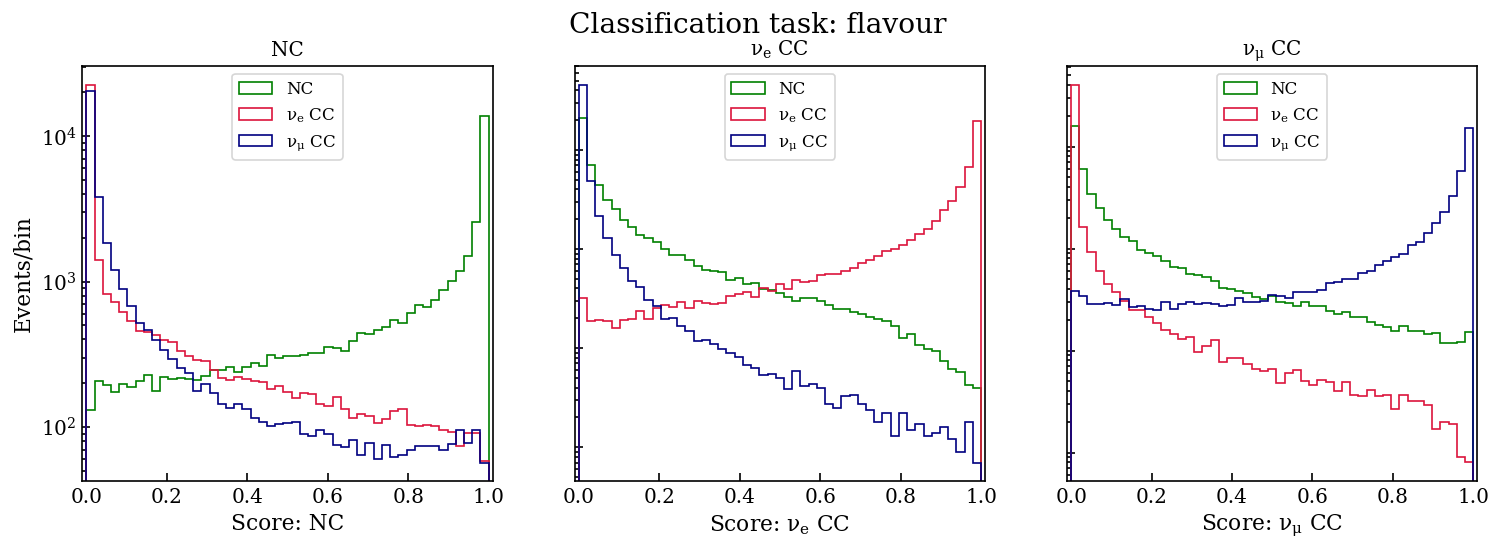

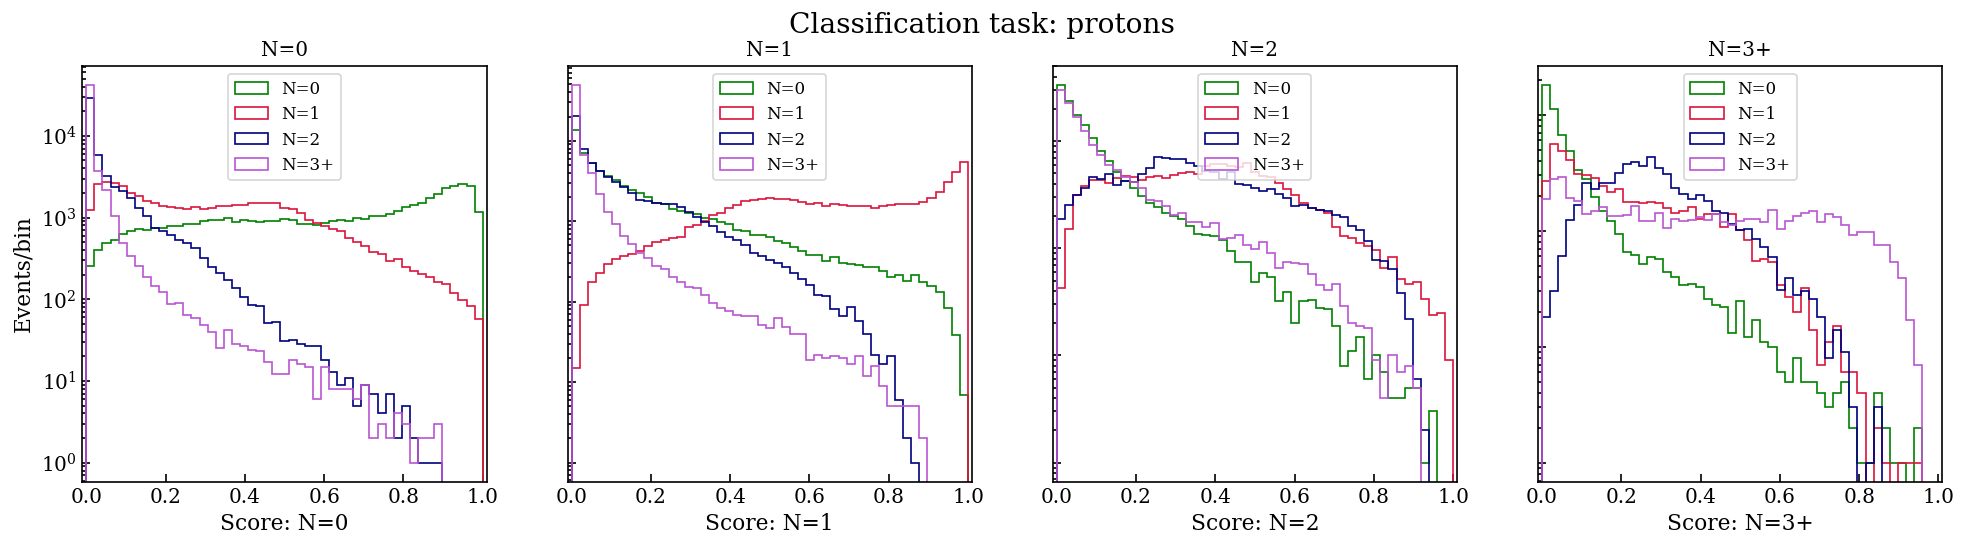

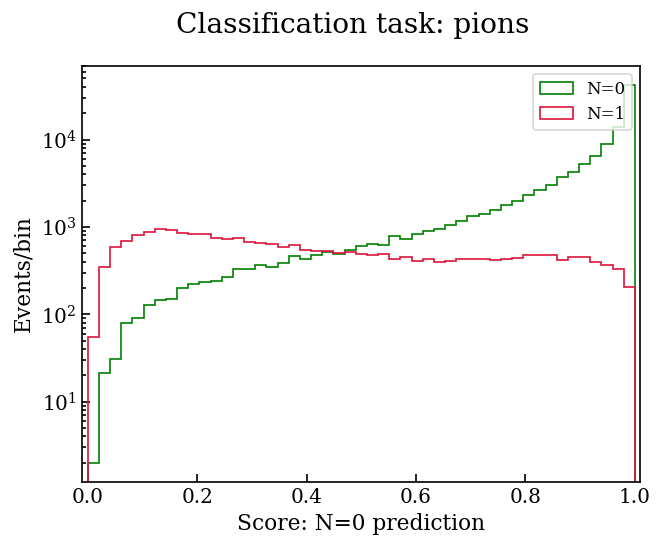

In [37]:
for cls_task in cls_tasks:
# cls_task = 'is_antineutrino' 
    num_in_pred = output_options[cls_tasks.index(cls_task)]
    class_options = np.arange(0, num_in_pred)
    cls_labels = key_labels[cls_task]
    
    if num_in_pred >2: 
        fig, axs = plt.subplots(1, len(class_options), figsize=(5*len(class_options),4.5))
        for cls, ax in zip(class_options, axs.flat):
            these_preds = pred[cls_tasks.index(cls_task)]
            for i in class_options:
                ax.hist(these_preds[true[cls_task]==cls][:,i], bins=np.linspace(0,1,50), histtype='step', label=cls_labels[i], color=colors[i])
                
            ax.legend(loc='upper center')
            ax.set(xlabel='Score: %s'%(cls_labels[cls]), ylabel='Events/bin', 
                   title=cls_labels[cls], 
                   xlim=(-0.01, 1.01), 
                   yscale='log', 
                  )
        
        for ax in axs.flat:
            ax.label_outer()
        fig.suptitle('Classification task: %s'%(cls_task))
        plt.savefig('model_eval_plots/%s/%s_predictions.pdf'%(model_name,cls_task))
        plt.show()
    
    else: 
        fig, ax = plt.subplots(1, figsize=(6,4.5))
        for cls in class_options:
            these_preds = pred[cls_tasks.index(cls_task)]
            
            ax.hist(these_preds[true[cls_task]==cls][:,0], bins=np.linspace(0,1,50), histtype='step', label=cls_labels[cls], color=colors[cls])
        ax.legend(loc='upper right')
        ax.set(xlabel='Score: %s prediction'%(cls_labels[0]), ylabel='Events/bin', 
               # title="Class, 
               xlim=(-0.01, 1.01), 
               yscale='log', 
              )
        fig.suptitle('Classification task: %s'%(cls_task))
        # plt.xlim(0,1)
        plt.savefig('model_eval_plots/%s/%s_predictions.pdf'%(model_name,cls_task))
        plt.show() 

In [12]:
def get_pred_class(pred_scores):
    if pred_scores.shape[1] == 1: 
        pred_class = np.int32(pred_scores+.5) #messy I know but they do 0-0.99 as 0 and 1-1.99 as 1. 
    else: 
        pred_class = np.argmax(pred_scores, axis=1)
    return pred_class

In [13]:
def calc_conf_int(confusion_matrix):
    ###
    # Calculate confidence intervals on the confusion matrix values.
    ###
    confidence_interval = np.zeros((confusion_matrix.shape[0],confusion_matrix.shape[1],2))
    for i in range(confusion_matrix.shape[1]):
        all_trials = np.sum(confusion_matrix[:,i])
        for j in range(confusion_matrix.shape[0]):
            successes = confusion_matrix[j,i]
            interval = beta.interval(0.68,successes+0.5,all_trials-successes+0.5,loc=0,scale=all_trials)
            if confusion_matrix[j,i] >= 1:
                confidence_interval[j,i,:] = [interval[1]-confusion_matrix[j,i], confusion_matrix[j,i]-interval[0]]
            else:
                confidence_interval[j,i,:] = [interval[1]-confusion_matrix[j,i],0]
                
    return confidence_interval


In [103]:
def plot_cm(confusion_matrix):
    confusion_matrix_t = confusion_matrix.T
    nclass = confusion_matrix_t.shape[0]
    fig, ax = plt.subplots(figsize=(1.5*nclass,1.5*nclass), facecolor='white')

    im = ax.imshow(confusion_matrix_t, norm=LogNorm(vmin=1.0, vmax=np.max(confusion_matrix_t)), cmap="YlGn", zorder=10)
    confidence_interval = calc_conf_int(confusion_matrix_t)
    for i in range(nclass):

        all_counts = np.sum(confusion_matrix_t[:,i])

        for j in range(nclass):

            percent = np.nan_to_num(100*confusion_matrix_t[j,i]      / all_counts)
            plus    = np.nan_to_num(100*confidence_interval[j,i,0] / all_counts)
            minus   = np.nan_to_num(100*confidence_interval[j,i,1] / all_counts)

            if percent == 100:
                text = ax.text(i, j, r'$100^{+0}_{-%0.3f}$%%' % (minus), ha="center", va="center", color=color_choice, fontsize=10, zorder=20)

            elif percent == 0:
                text = ax.text(i, j, r'$0^{+%0.3f}_{-0}$%%' % (plus), ha="center", va="center", color=color_choice, fontsize=10, zorder=20)

            else:
                text = ax.text(i, j, r'$%0.3f^{+%0.3f}_{-%0.3f} $%%' % (percent,plus,minus), ha="center", va="center", color=color_choice, fontsize=10, zorder=20)

    ax.set_axisbelow(True)
    ax.set_xticks(np.arange(0,nclass,1))
    ax.set_yticks(np.arange(0,nclass,1))
    labels = ['other', 'S1', 'S2'] if nclass==3 else ['S1', 'S2'] 
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels(labels, fontsize=12, ha='right', va='center')
    plt.xlim(-0.5,nclass-0.5)
    plt.ylim(nclass-0.5,-0.5)
    ax.set_xlabel('True Class', fontsize=12)
    ax.set_ylabel('Predicted Class', fontsize=12)
    # plt.savefig('confusion_matrix.png', bbox_inches='tight')
    # plt.show()

In [97]:
calc_conf_int(np.array(con_mat))

array([[[96.30827448, 97.12894798],
        [68.70672571, 68.3046394 ]],

       [[97.12894798, 96.30827448],
        [68.3046394 , 68.70672571]]])

3


/tmp/ipykernel_551/538507315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels['pions'] = np.clip(test_labels['pions'], 0, 1)


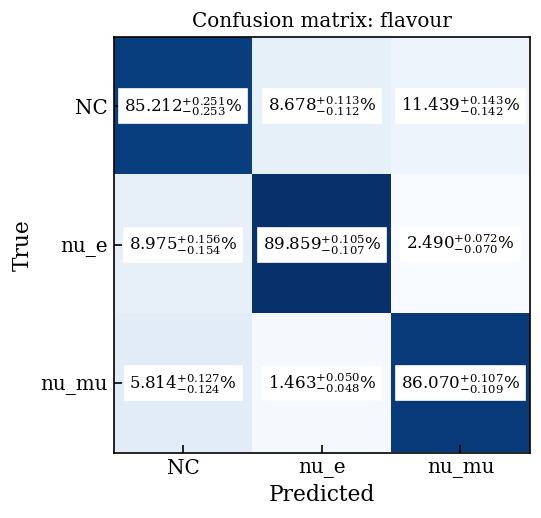

4


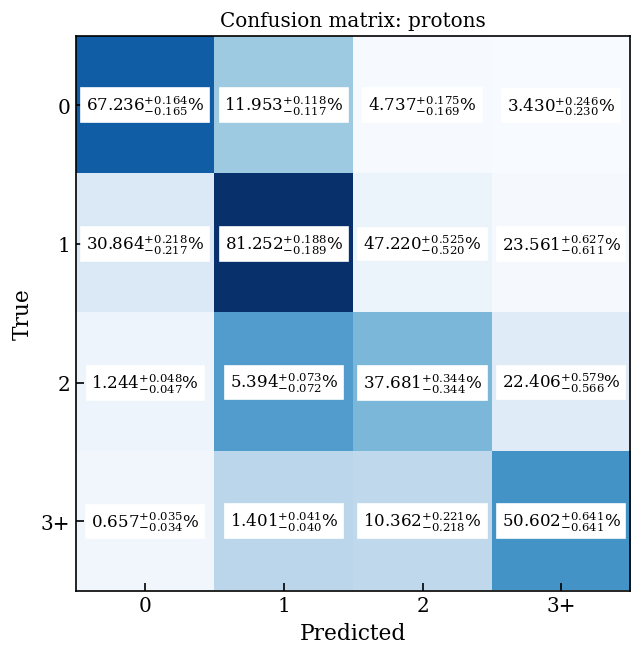

2


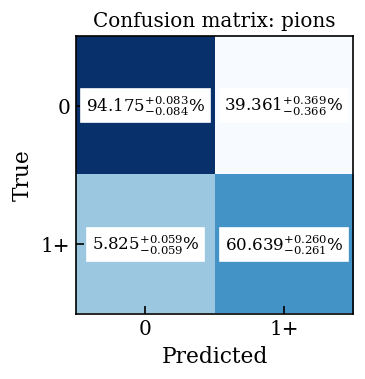

In [121]:
output_names=['flavour','protons','pions']
test_labels = test_data[output_names]
test_labels['pions'] = np.clip(test_labels['pions'], 0, 1)

# test_eval = model.evaluate(test_generator, verbose=4)
# pred

labels_flavour = ['NC', 'nu_e', 'nu_mu']
labels_n_particles = ['0', '1', '2', '3+']
labels_pi = ['0','1+']    
conmat_axis_labels = {'flavour': labels_flavour, 'protons': labels_n_particles, 
                 'pions': labels_pi,}

for i, ( predd, key) in enumerate(zip( pred, output_names)):
    num_labels = output_options[i]
    if num_labels ==1: num_labels = 2
    pred_classes = get_pred_class(predd)
    print(num_labels)
    con_mat = tf.math.confusion_matrix(np.asarray(test_labels[key][:len(predd)]), pred_classes, num_classes = num_labels)
    con_mat_norm = [con_mat[i]/sum(con_mat[i])*100 for i in range(len(con_mat))]
    con_mat_norm = np.round(con_mat_norm, 2)
    confidence_interval = calc_conf_int(np.asarray(con_mat))

    fig, ax = plt.subplots(figsize=(1.5*num_labels,1.5*num_labels), facecolor='white')
    for i in range(len(con_mat)):
        all_counts = np.sum(con_mat[i,:])
        for j in range(len(con_mat[i])):
            percent = np.nan_to_num(100*con_mat[i,j]      / all_counts)
            plus    = np.nan_to_num(100*confidence_interval[i,j,0] / all_counts)
            minus   = np.nan_to_num(100*confidence_interval[i,j,1] / all_counts)
    
    
            # plt.text(j-.3, i+.075, str(np.round(con_mat_norm[i][j], 1))+'%', c='k', backgroundcolor='w', fontsize=10)
            if percent == 100:
                text = ax.text(i, j, r'$100^{+0}_{-%0.3f}$%%' % (minus), ha="center", va="center",
                               c='k', backgroundcolor='w', fontsize=10, zorder=20)
        
            elif percent == 0:
                text = ax.text(i, j, r'$0^{+%0.3f}_{-0}$%%' % (plus), ha="center", va="center",
                               c='k', backgroundcolor='w', fontsize=10, zorder=20)
        
            else:
                text = ax.text(i, j, r'$%0.3f^{+%0.3f}_{-%0.3f} $%%' % (percent,plus,minus), ha="center", va="center",
                               c='k', backgroundcolor='w', fontsize=10, zorder=20)
    

    ax.imshow(con_mat_norm, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    labels = conmat_axis_labels[key]
    plt.xticks(np.arange(num_labels), labels)
    plt.yticks(np.arange(num_labels), labels)
    # plt.colorbar(label='Percent of True Values Predicted')
    plt.title('Confusion matrix: %s'%(key))
    ### CHANGE PATH
    # plt.savefig('/home/sophiaf/Classification-with-ML/neutrino-classification/CNN/plots/'+args.test_name+'_con_mat_'+key+'.pdf')
    plt.show()

### Tried and works version: 

/tmp/ipykernel_551/994681774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels['pions'] = np.clip(test_labels['pions'], 0, 1)


3


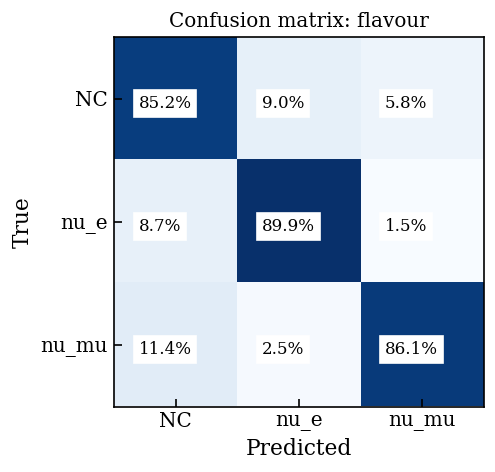

4


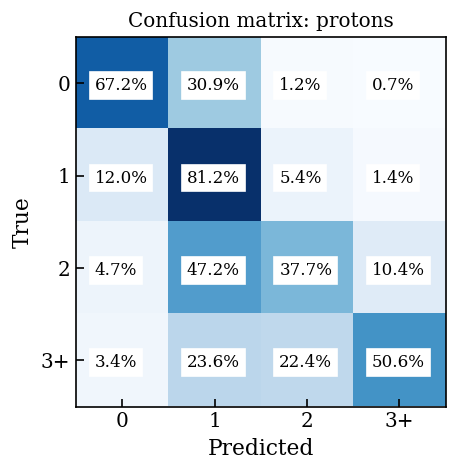

2


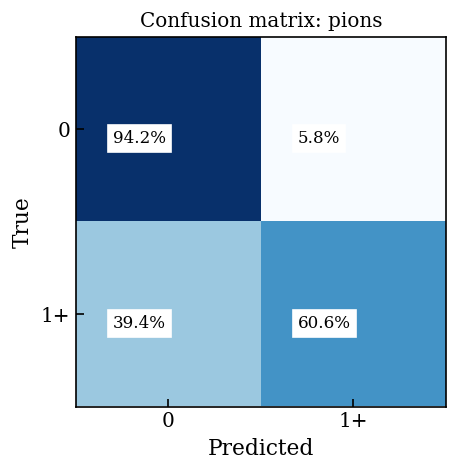

In [122]:
output_names=['flavour','protons','pions']
test_labels = test_data[output_names]
test_labels['pions'] = np.clip(test_labels['pions'], 0, 1)

# test_eval = model.evaluate(test_generator, verbose=4)
# pred

labels_flavour = ['NC', 'nu_e', 'nu_mu']
labels_n_particles = ['0', '1', '2', '3+']
labels_pi = ['0','1+']    
conmat_axis_labels = {'flavour': labels_flavour, 'protons': labels_n_particles, 
                 'pions': labels_pi,}

for i, ( predd, key) in enumerate(zip( pred, output_names)):
    num_labels = output_options[i]
    if num_labels ==1: num_labels = 2
    pred_classes = get_pred_class(predd)
    print(num_labels)
    con_mat = tf.math.confusion_matrix(np.asarray(test_labels[key][:len(predd)]), pred_classes, num_classes = num_labels)
    con_mat_norm = [con_mat[i]/sum(con_mat[i])*100 for i in range(len(con_mat))]
    con_mat_norm = np.round(con_mat_norm, 2)
    
    plt.figure()
    for i in range(len(con_mat)):
        for j in range(len(con_mat[i])):
            plt.text(j-.3, i+.075, str(np.round(con_mat_norm[i][j], 1))+'%', c='k', backgroundcolor='w', fontsize=10)
    plt.imshow(con_mat_norm, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    labels = conmat_axis_labels[key]
    plt.xticks(np.arange(num_labels), labels)
    plt.yticks(np.arange(num_labels), labels)
    # plt.colorbar(label='Percent of True Values Predicted')
    plt.title('Confusion matrix: %s'%(key))
    ### CHANGE PATH
    plt.savefig('/home/sophiaf/Classification-with-ML/neutrino-classification/CNN/plots/'+model+'_con_mat_'+key+'.pdf')
    plt.show()

In [15]:
mask_1p_0pi = true['flavour']!=0 #not NC 
mask_1p_0pi &= true['protons']==1
mask_1p_0pi &= true['pions']==0
cc_1p_0pi = true[mask_1p_0pi]
print(sum(mask_1p_0pi))
print('Fraction of nu/(nu+nubar): %.2f'%(sum(cc_1p_0pi["is_antineutrino"]==0)/len(cc_1p_0pi)))

45454


KeyError: 'is_antineutrino'

In [14]:
mask_0p_0pi = true['flavour']!=0 #not NC 
mask_0p_0pi &= true['protons']==0
mask_0p_0pi &= true['pions']==0
cc_0p_0pi = true[mask_0p_0pi]
print(sum(mask_0p_0pi))
print('Fraction of nu/(nu+nubar): %.2f'%(sum(cc_0p_0pi["is_antineutrino"]==0)/len(cc_0p_0pi)))

32220
Fraction of nu/(nu+nubar): 0.60


In [15]:
mask_2p_0pi = true['flavour']!=0 #not NC 
mask_2p_0pi &= true['protons']==2
mask_2p_0pi &= true['pions']==0
cc_2p_0pi = true[mask_2p_0pi]
print(sum(mask_2p_0pi))
print('Fraction of nu/(nu+nubar): %.2f'%(sum(cc_2p_0pi["is_antineutrino"]==0)/len(cc_2p_0pi)))

9092
Fraction of nu/(nu+nubar): 0.94


### Decision boundary on NC/CC: 

We're interested in keeping the CC. It looks like we can keep CC flavor-agnostic in this case. 

In [16]:
pred = tests['pred']
true = tests['true'].iloc[:len(pred[0])] # batches cut off preds 

In [17]:
len(pred[0])

142272

In [18]:
len(true)

142272

In [19]:
flav_preds = pred[0]
cc_score = np.sum(flav_preds[:,1:], axis=1)
nc_score = flav_preds[:,0]

In [20]:
from matplotlib.colors import LogNorm

In [21]:
mask_nc = true['flavour']==0
mask_cc = true['flavour']>0

In [22]:
xs = np.linspace(0,1,200)
efficiency = np.zeros_like(xs)
purity = np.zeros_like(xs)
all_true_cc = true[mask_cc]

for i, x in enumerate(xs): 
    nue_cc_pass = flav_preds[:,1]>x
    numu_cc_pass = flav_preds[:,2]>x
    cc_pass = np.logical_or(nue_cc_pass, numu_cc_pass)
    cc_true_pass = np.logical_and(cc_pass, true['flavour']>0)
    efficiency[i] = sum(cc_true_pass)/len(all_true_cc)
    purity[i] = sum(cc_true_pass)/(sum(cc_pass)+1e-5)

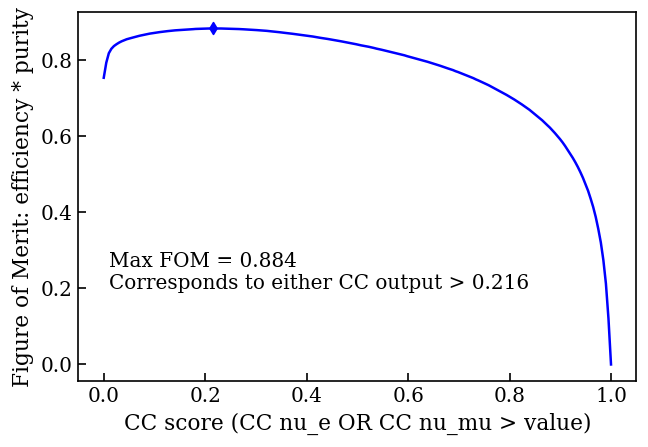

In [23]:
fom = efficiency*purity
plt.plot(xs, fom)
plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
# plt.plot(xs, purity)
plt.ylabel('Figure of Merit: efficiency * purity')
plt.xlabel('CC score (CC nu_e OR CC nu_mu > value)')
plt.text(0.01, 0.2, 'Max FOM = %.3f \nCorresponds to either CC output > %.3f'%(np.max(fom), xs[np.argmax(fom)]), fontsize=12)
plt.savefig('model_eval_plots/%s/fom.pdf'%(model_name))
plt.show()


In [24]:
def cc_mask(preds, bound):
    nue_cc_pass = preds[:,1]>bound
    numu_cc_pass = preds[:,2]>bound
    cc_pass = np.logical_or(nue_cc_pass, numu_cc_pass)
    return cc_pass

def nc_mask(preds, bound):
    not_nc = preds[:,0]<bound
    return not_nc    

/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:25: RuntimeWarning: divide by zero encountered in log
  epsilon_to_the_power_of_k = k*np.log(epsilon)
/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:33: RuntimeWarning: divide by zero encountered in log
  n_k_to_the_power_1_epsilon = (n - k)*np.log(1 - epsilon)


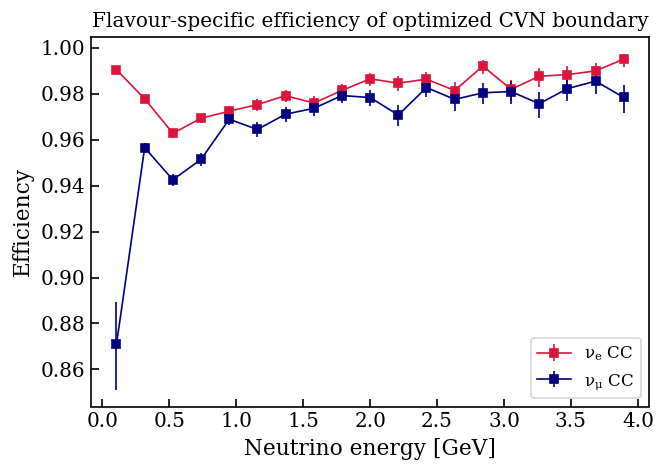

In [82]:
# efficiency as a function of energy 
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):

        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = cc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound
        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/n
        sigma_eff = compute_acceptance_uncertainty_bayesian(k,n)[0]
        sigma_effs[:,i] = np.abs(compute_acceptance_uncertainty_bayesian(k,n)[0]- effs[i])
        compute_acceptance_uncertainty_bayesian(k,n)[0]
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='s')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('Neutrino energy [GeV]')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
plt.savefig('model_eval_plots/%s/efficiency_energy.pdf'%(model_name))
plt.show()        

/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:25: RuntimeWarning: divide by zero encountered in log
  epsilon_to_the_power_of_k = k*np.log(epsilon)
/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:33: RuntimeWarning: divide by zero encountered in log
  n_k_to_the_power_1_epsilon = (n - k)*np.log(1 - epsilon)


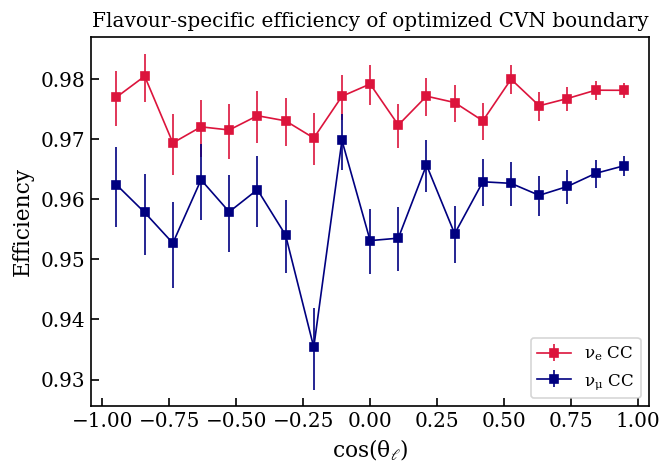

In [83]:
# efficiency as a function of lepton angle  
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(-1,1,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = np.cos(true_meta['LepAngle']) >= e_min
        e_mask &= np.cos(true_meta['LepAngle']) < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = cc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound
        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/(n+1e-2)
        sigma_eff = compute_acceptance_uncertainty_bayesian(k,n)[0]
        sigma_effs[:,i] = np.abs(compute_acceptance_uncertainty_bayesian(k,n)[0]- effs[i])
        compute_acceptance_uncertainty_bayesian(k,n)[0]
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='s')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('cos($\\theta_{\\ell}$)')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
plt.savefig('model_eval_plots/%s/efficiency_theta_l.pdf'%(model_name))

plt.show()        

In [27]:
xs = np.linspace(0,1,200)
efficiency = np.zeros_like(xs)
purity = np.zeros_like(xs)
all_true_nc = true[mask_nc]

for i, x in enumerate(xs): 
    cc_pass = flav_preds[:,0]<x
    cc_true_pass = np.logical_and(cc_pass, true['flavour']>0)
    efficiency[i] = sum(cc_true_pass)/len(all_true_cc)
    purity[i] = sum(cc_true_pass)/(sum(cc_pass)+1e-5)

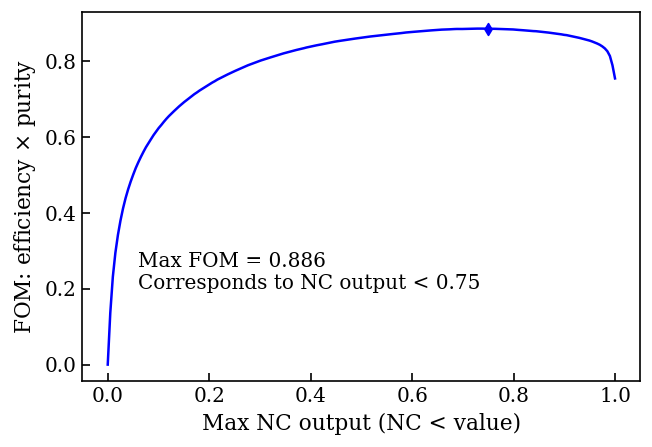

In [28]:
fom = efficiency*purity
plt.plot(xs, fom)
plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
# plt.plot(xs, purity)
plt.ylabel('FOM: efficiency $\\times$ purity')
plt.xlabel('Max NC output (NC < value)')
plt.text(0.06, 0.2, 'Max FOM = %.3f \nCorresponds to NC output < %.2f'%(np.max(fom), xs[np.argmax(fom)]), fontsize=12)
plt.savefig('model_eval_plots/%s/fom_nc.pdf'%(model))
plt.show()


In [ ]:
purity[i] = sum(cc_true_pass)/(sum(cc_pass)+1e-5)

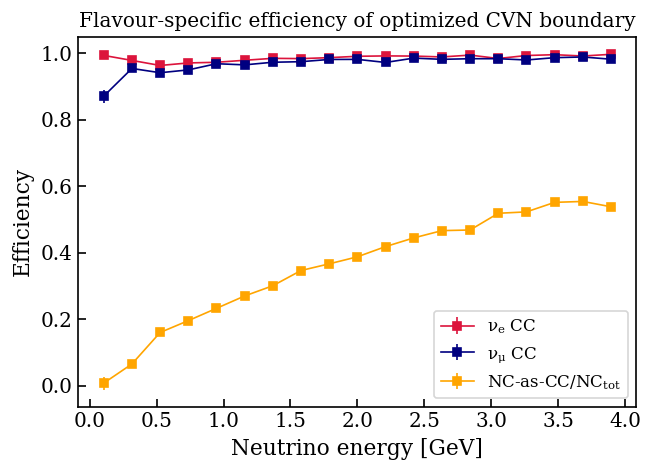

In [33]:
# efficiency as a function of energy 
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))
impurity = np.zeros_like(e_means) 

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):

        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = nc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound

        true_nc_in_e = true_in_e['flavour']==0
        pass_nc_in_e = true_nc_in_e * pred_cc_in_e
        impurity[i] = sum(pass_nc_in_e)/(sum(true_nc_in_e)+1e-5)

        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/n
        sigma_eff = compute_acceptance_uncertainty_bayesian(k,n)[0]
        sigma_effs[:,i] = np.abs(compute_acceptance_uncertainty_bayesian(k,n)[0]- effs[i])
        compute_acceptance_uncertainty_bayesian(k,n)[0]
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='s')
plt.errorbar(e_means, impurity, yerr = sigma_effs, 
                 label='NC-as-CC/NC$_{tot}$', color='orange', linewidth=1, marker='s')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('Neutrino energy [GeV]')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
# plt.savefig('model_eval_plots/%s/efficiency_ncdef_energy.pdf'%(model))
plt.show()        

In [30]:
purity

array([0.        , 0.99918189, 0.99803465, 0.99726518, 0.99656246,
       0.99583931, 0.99504795, 0.99418666, 0.99345104, 0.99299194,
       0.99221683, 0.99158565, 0.99109456, 0.99045043, 0.9900474 ,
       0.98957239, 0.98922918, 0.98859042, 0.9880505 , 0.98756653,
       0.98717351, 0.98655829, 0.98611052, 0.98564921, 0.98507916,
       0.98470802, 0.98418252, 0.98360371, 0.98315625, 0.98256141,
       0.98199403, 0.98155656, 0.98092139, 0.98044947, 0.98016371,
       0.97969486, 0.97928987, 0.9787451 , 0.97809142, 0.9776962 ,
       0.97714471, 0.97670832, 0.97614832, 0.97574398, 0.97517818,
       0.97479737, 0.97421543, 0.97366445, 0.97332276, 0.97283945,
       0.97237142, 0.97201459, 0.97156644, 0.97110832, 0.97061122,
       0.97013416, 0.96967181, 0.96930419, 0.96889343, 0.96837409,
       0.96788351, 0.96739614, 0.96678987, 0.96620116, 0.96576584,
       0.96526991, 0.96485586, 0.96431755, 0.96374788, 0.96318579,
       0.96259778, 0.96190506, 0.96152964, 0.96099523, 0.96040

/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:25: RuntimeWarning: divide by zero encountered in log
  epsilon_to_the_power_of_k = k*np.log(epsilon)
/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:33: RuntimeWarning: divide by zero encountered in log
  n_k_to_the_power_1_epsilon = (n - k)*np.log(1 - epsilon)


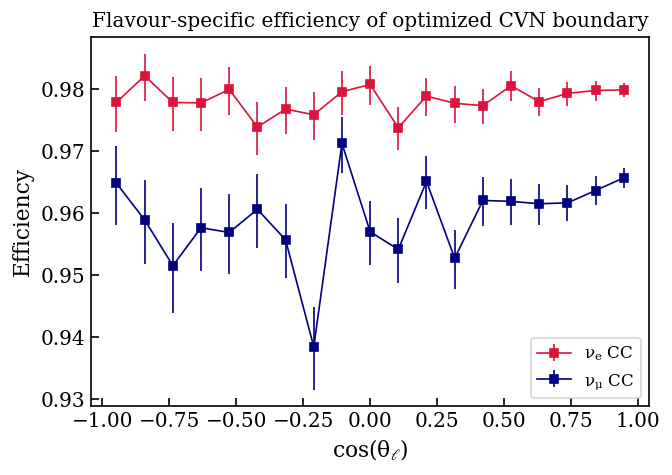

In [132]:
# efficiency as a function of lepton angle  
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(-1,1,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = np.cos(true_meta['LepAngle']) >= e_min
        e_mask &= np.cos(true_meta['LepAngle']) < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = nc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound
        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/(n+1e-2)
        sigma_eff = compute_acceptance_uncertainty_bayesian(k,n)[0]
        sigma_effs[:,i] = np.abs(compute_acceptance_uncertainty_bayesian(k,n)[0]- effs[i])
        compute_acceptance_uncertainty_bayesian(k,n)[0]
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='s')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('cos($\\theta_{\\ell}$)')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
plt.savefig('model_eval_plots/%s/ncdef_efficiency_theta_l.pdf'%(model_name))

plt.show()        

## Decision boundary on flavor 